In [1]:
%reload_ext autoreload
%autoreload 2

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# To-Do List
# 0. Plot valueAgentELO results effectively and document it!
# 1. Train a library of lineValueAgents on a server
# 3. Build a policy-only agent!
#    - It will learn with a network approximation of the value function in the same way the other ones do
#    - But it'll process the hand and game state to generate a context embedding -----
#    - Then use a pointer network to choose which option to play based on the option encoding and the context
#    - The policy can then be updated with the temporal-difference of the value function, which will get more efficient over time

# Experiments: 
# 1. Show that the order of the agents matter (i.e. going after a good agent makes it harder!)
# 2. Compare lineValueNetwork trained on only it's turn vs. all turns vs. just it's turn and the next turn
# 4. Compare value agents trained with hand-continuity of eligibility traces or resets...

# Analysis Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output
# 4. Analyze why the abrupt increases in loss happen during pointer demonstration
#    - add the analysis of seqLength vs. loss and position-dependent error to analyze the spikes in the loss

# restructure experiments so they save key data points and divide the data generation and the analysis 
# so I can run it in "analysis" mode where it just loads data from a prespecified filename...
# ---- keeping the above here because I don't think it's done for all of them yet ------


In [266]:
# Immediate to-do
# 1. Finish up transition to REINFORCE algorithm for pointer sequencing
#    - also do this for the pointer demonstration
# 2. Then use a separate value network to force the encoding to learn how to predict the value of the pointer output.
# 3. Switch it to generate an output based on a randomized turn schedule (e.g. possibly be cutoff from generating output and accruing value)
#    - Predict this with a value function too. 
# 4. Divide pointer network into "encoder" and "decoder" blocks to reuse the encoder (and append value)
# 5. Try new versions of pointer attention:
#    - simple attention (not a transformer layer) then single (N -> 1) FF layer
#    - dot product between decoder_context and encoded_representations then softmax over that
# --
# also
# --
# 1. Test simpler TD agents on a probability of winning based value, rather than score!


# Code practice:
# 1. Convert measure reward to class
# 2. Make a class for all these methods going to the experiments (batch, pad, etc.)

# Representations:
# 1. Make clean and nicely stored system for representing outputs in hand sequencing

In [2]:
# code for generating a hand

def randomDominoeHand(numInHand, listDominoes, highestDominoe, batch_size=1, null_token=True, available_token=True):
    """method to produce an encoded random hand"""
    numDominoes = len(listDominoes)
    
    # choose dominoes from the batch, and get their value (in points)
    selection = np.stack([np.random.choice(numDominoes, numInHand, replace=False) for _ in range(batch_size)])
    if available_token:
        available = np.random.randint(0, highestDominoe+1, batch_size)
    else:
        available = [None]*batch_size
    
    # create tensor representations
    input = torch.stack([df.twohotDominoe(sel, listDominoes, highestDominoe, available=ava,
                                          available_token=available_token, null_token=null_token, with_batch=False) 
                         for sel,ava in zip(selection, available)])
    return input, selection, available
    
def getBestLine(dominoes, selection, highestDominoe):
    bestSequence = []
    bestDirection = []
    for sel in selection:
        cBestSeq = []
        cBestDir = []
        cBestVal = []
        for available in range(highestDominoe+1):
            cseq, cdir = df.constructLineRecursive(dominoes, sel, available)
            cval = [np.sum(dominoes[cs]) for cs in cseq]
            cidx = max(enumerate(cval), key=lambda x: x[1])[0]
            cBestSeq.append(cseq[cidx])
            cBestDir.append(cdir[cidx])
            cBestVal.append(cval[cidx])

        cBestIdx = max(enumerate(cBestVal), key=lambda x: x[1])[0]
        bestSequence.append(cBestSeq[cBestIdx])
        bestDirection.append(cBestDir[cBestIdx])

    return bestSequence, bestDirection

def getBestLineFromAvailable(dominoes, selection, highestDominoe, available):
    bestSequence = []
    bestDirection = []
    for sel, ava in zip(selection, available):
        cseq, cdir = df.constructLineRecursive(dominoes, sel, ava)
        cval = [np.sum(dominoes[cs]) for cs in cseq]
        cidx = max(enumerate(cval), key=lambda x: x[1])[0]
        bestSequence.append(cseq[cidx])
        bestDirection.append(cdir[cidx])
    return bestSequence, bestDirection
    
def convertToHandIndex(selection, bestSequence):
    indices = []
    for sel,seq in zip(selection, bestSequence):
        # look up table for current selection
        elementIdx = {element:idx for idx, element in enumerate(sel)}
        indices.append([elementIdx[element] for element in seq])
    return indices
    
def padBestLine(bestSequence, max_output, ignore_index=-1):
    for bs in bestSequence:
        bs += [ignore_index]*(max_output-len(bs))
    return bestSequence

def generateBatch(highestDominoe, dominoes, batch_size, numInHand, return_target=True,
                  available_token=False, null_token=False, ignore_index=-1, return_full=False):
    input, selection, available = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token, available_token=available_token)

    mask_tokens = numInHand + (1 if null_token else 0) + (1 if available_token else 0)
    mask = torch.ones((batch_size, mask_tokens), dtype=torch.float)

    if return_target:
        # then measure best line and convert it to a "target" array
        if available_token:
            bestSequence, bestDirection = getBestLineFromAvailable(dominoes, selection, highestDominoe, available)
        else:
            bestSequence, bestDirection = getBestLine(dominoes, selection, highestDominoe)

        # convert sequence to hand index
        iseq = convertToHandIndex(selection, bestSequence)
        # create target and append null_index for ignoring impossible plays
        null_index = ignore_index if not(null_token) else numInHand
        target = torch.tensor(np.stack(padBestLine(iseq, numInHand+(1 if null_token else 0), ignore_index=null_index)), dtype=torch.long)
    else:
        # otherwise set these to None so we can use the same return structure
        target, bestSequence, bestDirection = None, None, None
        
    if return_full:
        return input, target, mask, bestSequence, bestDirection, selection, available
    return input, target, mask

In [3]:
@torch.no_grad()
def measureReward(available, hands, choices, normalize=True, return_direction=False, verbose=None):
    assert choices.ndim==2, f"choices should be a (batch_size, max_output) tensor of indices, it is: {choices.shape}"
    batch_size, max_output = choices.shape
    num_in_hand = hands.shape[1]
    device = transformers.get_device(choices)

    # check verbose
    if verbose is not None:
        debug = True
        assert 0 <= verbose < batch_size, "verbose should be an index corresponding to one of the batch elements"
    else:
        debug = False
    
    # initialize these tracker variables
    next_available = torch.tensor(available, dtype=torch.float).to(device)
    havent_played = torch.ones((batch_size, num_in_hand+1), dtype=torch.bool).to(device) # True until dominoe has been played (include null for easier coding b/c out_choices includes idx to null
    hands = torch.tensor(hands, dtype=torch.float).to(device)
    handsOriginal = torch.cat((hands, -torch.ones((hands.size(0),1,2)).to(device)), dim=1) # keep track of original values
    handsUpdates = torch.cat((hands, -torch.ones((hands.size(0),1,2)).to(device)), dim=1) # Add null choice as [-1,-1]
    
    rewards = torch.zeros((batch_size, max_output), dtype=torch.float).to(device)
    if return_direction: 
        direction = -torch.ones((batch_size, max_output), dtype=torch.float).to(device)

    if debug:
        print("Original hand:\n", hands[verbose])
        
    # then for each output:
    for idx in range(max_output):
        # idx of outputs that chose the null token
        idx_null = choices[:,idx] == num_in_hand

        if debug:
            print('')
            print("\nNew loop in measure reward:\n")
            print("next_available:", next_available[verbose])
            print("Choice: ", choices[verbose,idx])
            print("IdxNull: ", idx_null[verbose])
        
        # idx of outputs that have not already been chosen
        idx_not_played = torch.gather(havent_played, 1, choices[:, idx].view(-1,1)).squeeze(1)
        havent_played.scatter_(1, choices[:,idx].view(-1,1), torch.zeros((batch_size,1), dtype=torch.bool).to(device))

        # idx of play (not the null token and a dominoe that hasn't been played yet)
        idx_play = ~idx_null & idx_not_played
        
        # the dominoe that is chosen (including the null token)
        next_play = torch.gather(handsOriginal, 1, choices[:, idx].view(-1, 1, 1).expand(-1, 1, 2)).squeeze(1)

        # figure out whether play was valid, whcih direction, and next available
        valid_play = torch.any(next_play.T == next_available, 0) # figure out if available matches a value in each dominoe
        next_value_idx = 1*(next_play[:,0]==next_available) # if true, then 1 is next value, if false then 0 is next value (for valid plays)
        new_available = torch.gather(next_play, 1, next_value_idx.view(-1,1)).squeeze(1) # get next available value
        next_available[valid_play] = new_available[valid_play] # update available for all valid plays

        # after getting next play, set any dominoe that has been played to [-1, -1]
        insert_values = next_play.clone()
        insert_values[valid_play] = -1
        handsUpdates.scatter_(1, choices[:, idx].view(-1,1,1).expand(-1,-1,2), insert_values.unsqueeze(1))

        if return_direction:
            play_direction = 1.0*(next_value_idx==0)
            direction[idx_play & valid_play, idx] = play_direction[idx_play & valid_play].float()
            
        # if dominoe that is a valid_play and hasn't been played yet is selected, add reward
        idx_good_play = ~idx_null & idx_not_played & valid_play
        rewards[idx_good_play, idx] += (torch.sum(next_play[idx_good_play], dim=1) + 1)
    
        # if a dominoe is chosen but is invalid, subtract points
        idx_bad_play = ~idx_null & (~idx_not_played | ~valid_play)
        rewards[idx_bad_play, idx] -= (torch.sum(next_play[idx_bad_play], dim=1) + 1)

        # determine which hands still have playable dominoes
        idx_still_playable = torch.any((handsUpdates == next_available.view(-1, 1, 1)).view(handsUpdates.size(0), -1), dim=1)

        # if the null is chosen and no other dominoes are possible, give some reward, otherwise negative reward
        rewards[idx_null & ~idx_still_playable, idx] += 1.0
        rewards[idx_null & idx_still_playable, idx] -= 1.0

        if debug:
            print("Next play: ", next_play[verbose])
            if return_direction:
                print("play_direction:", play_direction[verbose])
            print("next available: ", next_available[verbose])
            print("valid_play:", valid_play[verbose])
            print("idx_still_playable:", idx_still_playable[verbose])
            print("idx_play: ", idx_play[verbose])
            print("Hands updated:\n", handsUpdates[verbose])
            print("Rewards[verbose,idx]:", rewards[verbose, idx])
    
    if normalize:
        rewards /= (highestDominoe+1) 
        
    if return_direction:
        return rewards, direction
    else:        
        return rewards

R=27.39, G=32.70: 100%|████████████████████████████████████████████████████████████| 4000/4000 [13:51<00:00,  4.81it/s]


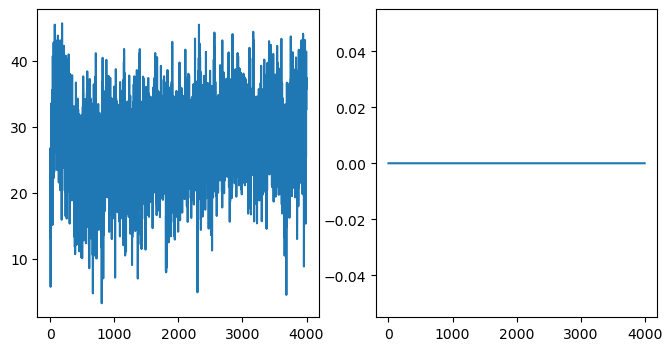

In [274]:
# This section of code does curriculum training
# - starting with supervised learning of dominoe sequences
# - then ending with reinforcement learning

# input parameters
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)

batch_size = 96
numInHand = 10
null_token = True
available_token = True
input_dim = (3 if available_token else 2)*(highestDominoe+1) + (1 if null_token else 0)
embedding_dim = 96
num_output = numInHand + (1 if null_token else 0)
ignore_index = -1
alpha = 1e-4

# get network from saved 
net = torch.load('experiments/savedNetworks/pointerSequencer.pt')
net.temperature = 10

# net = transformers.PointerNetwork(input_dim, embedding_dim, encoding_layers=2, heads=8, expansion=2, kqnorm=True, decode_with_gru=False, greedy=False)

net.to(device)
net.train()

# prepare optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=alpha, weight_decay=alpha*1e-2)

gamma = 0.3
exponent = torch.arange(numInHand+1).view(-1,1) - torch.arange(numInHand+1).view(1,-1)
gamma_transform = (gamma ** exponent * (exponent >= 0)).unsqueeze(0).expand(batch_size, -1, -1).to(device)

# run round
use_rl = True
if_rl_measure_loss = False
return_target = not(use_rl) or if_rl_measure_loss

# do reinforcement learning
rl_batch_inputs = {'null_token':null_token, 
                   'available_token':available_token, 
                   'ignore_index':ignore_index, 
                   'return_full':True,
                   'return_target':return_target
                  }

numEpochs = 4000
rlReward = torch.zeros((numEpochs,))
slLoss = torch.zeros((numEpochs,))
for epoch in (pbar := tqdm(range(numEpochs))):
    
    if epoch == int(numEpochs*0.9):
        net.temperature=1
    
    optimizer.zero_grad()

    # generate input batch
    batch = generateBatch(highestDominoe, dominoes, batch_size, numInHand, **rl_batch_inputs)

    # unpack batch tuple
    input, target, _, _, _, selection, available = batch

    # move to correct device
    input = input.to(device)
    if return_target:
        target = target.to(device)

    # convert input to main input and context input
    x, context = input[:, :-1], input[:, [-1]]
    input = (x, context)
    
    # propagate it through the network
    out_scores, out_choices = net(input, max_output=num_output)

    # measure rewards for each sequence
    rewards = measureReward(available, dominoes[selection], out_choices, normalize=False)
    G = torch.bmm(rewards.unsqueeze(1), gamma_transform).squeeze(1)
    
    # measure loss and do backward pass
    if return_target:
        unrolled = out_scores.view(batch_size * num_output, -1)
        loss = torch.nn.functional.nll_loss(unrolled, target.view(-1), ignore_index=ignore_index)
        c_loss = loss.item()
    else:
        c_loss = 0
        
    if use_rl:
        # figure out which choices were the null
        idx_null = out_choices == numInHand
    
        # idx=True where a choice happened in which null was already selected
        idx_had_null = torch.cumsum(idx_null, dim=1) > 0
        
        # Convert rewards to J 
        logprob_policy = torch.gather(out_scores, 2, out_choices.unsqueeze(2)).squeeze(2) # log-probability for each chosen dominoe

        # do backward pass on J
        j_sum_argument = logprob_policy * G
        J = -torch.sum(j_sum_argument) # only include components where a valid choice was made
        J.backward()
    else:
        # if not doing RL, then do backward pass from supervised loss
        loss.backward()
        
    optimizer.step()
    rlReward[epoch] = torch.mean(torch.sum(G, dim=1))
    slLoss[epoch] = c_loss
    pbar.set_description(f"R={torch.mean(torch.sum(rewards, dim=1)):.2f}, G={rlReward[epoch]:.2f}")


plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(numEpochs), rlReward)
ax[1].plot(range(numEpochs), slLoss)
plt.show()

In [277]:
hands = torch.tensor(dominoes[selection]).to(device)
handsPrint = torch.cat((hands, -torch.ones((hands.shape[0], 1, 2)).to(device)), dim=1)
choices = out_choices

ii = 1
print("Hand: \n", hands[ii])
print("Choices: \n", choices[ii])
if return_target:
    print("Target: \n", target[ii])
print("Available: \n", available[ii])
print("Dom Output: \n", handsPrint[ii][choices[ii]])
print("Rewards: \n", rewards[ii])

Hand: 
 tensor([[6, 9],
        [2, 5],
        [3, 7],
        [4, 7],
        [1, 5],
        [0, 1],
        [7, 9],
        [4, 8],
        [1, 6],
        [2, 4]], device='cuda:0', dtype=torch.int32)
Choices: 
 tensor([2, 6, 0, 8, 4, 4, 7, 1, 1, 1, 1], device='cuda:0')
Available: 
 3
Dom Output: 
 tensor([[3., 7.],
        [7., 9.],
        [6., 9.],
        [1., 6.],
        [1., 5.],
        [1., 5.],
        [4., 8.],
        [2., 5.],
        [2., 5.],
        [2., 5.],
        [2., 5.]], device='cuda:0')
Rewards: 
 tensor([ 11.,  17.,  16.,   8.,   7.,  -7., -13.,  -8.,  -8.,  -8.,  -8.],
       device='cuda:0')


In [263]:
# _ = measureReward(available, dominoes[selection], out_choices, normalize=False, return_direction=True, verbose=0)

Training network...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:01<00:00,  4.11it/s]


Testing network...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.78it/s]


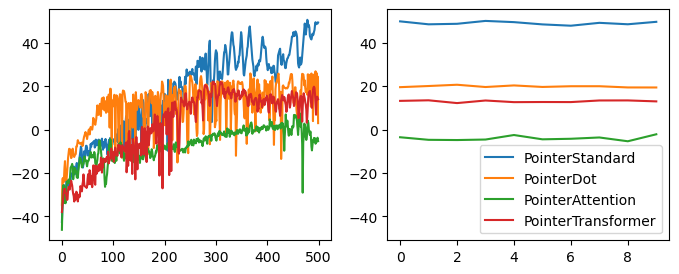

In [23]:
#### set up toy experiment with a simple problem and pointer network to test the REINFORCE algorithm
# start with 'pointerDemonstration' code and reward dominoes in order of highest value, not rewarding already played dominoes, and discounting future dominoes...

@torch.no_grad()
def measureReward(hands, choices, normalize=True):
    assert choices.ndim==2, "choices should be a (batch_size, max_output) tensor of indices"
    batch_size, max_output = choices.shape
    num_in_hand = hands.shape[1]
    device = transformers.get_device(choices)
    
    # initialize these tracker variables
    havent_played = torch.ones((batch_size, num_in_hand), dtype=torch.bool).to(device) # True until dominoe has been played (include null for easier coding b/c out_choices includes idx to null
    hands = torch.tensor(hands, dtype=torch.float).to(device)
    
    rewards = torch.zeros((batch_size, max_output), dtype=torch.float).to(device)
    last_value = 10000*torch.ones((batch_size, ), dtype=torch.float).to(device) # initialize last value high
    
    # then for each output:
    for idx in range(max_output):
        # for next choice, get bool of whether choice has already been played
        idx_not_played = torch.gather(havent_played, 1, choices[:, idx].view(-1,1)).squeeze(1)

        # update which dominoes have been played
        havent_played.scatter_(1, choices[:,idx].view(-1,1), torch.zeros((batch_size,1), dtype=torch.bool).to(device))

        # for dominoes that haven't been played, add their value to rewards
        next_play = torch.gather(hands, 1, choices[:, idx].view(-1,1,1).expand(-1,1,2)).squeeze(1)
        value_play = torch.sum(next_play, dim=1)

        # check if it's lower in value
        idx_smaller = (value_play <= last_value) & idx_not_played
        last_value[idx_smaller] = value_play[idx_smaller]
        
        # add reward for valid plays, subtract for invalid
        rewards[idx_smaller, idx] += (value_play[idx_smaller] + 1)
        rewards[~idx_smaller, idx] -= (value_play[~idx_smaller] + 1)
        
    if normalize:
        rewards /= torch.max(hands)

    return rewards

# get values from the argument parser
highestDominoe = 9
listDominoes = df.listDominoes(highestDominoe)
dominoeValue = np.sum(listDominoes, axis=1)

ignoreIndex = -1
handSize = 8
batchSize = 512

input_dim = 2*(highestDominoe+1)
embedding_dim = 48
heads = 4
encoding_layers = 1
greedy = True
temperature = 5
maxOutput = 6 # handSize

trainEpochs = 500
testEpochs = 10

gamma = 0.5
exponent = torch.arange(maxOutput).view(-1,1) - torch.arange(maxOutput).view(1,-1)
gamma_transform = (gamma ** exponent * (exponent >= 0)).unsqueeze(0).expand(batchSize, -1, -1).to(device)


# do reinforcement learning
batch_inputs = {'null_token':False, 
                'available_token':False, 
                'ignore_index':ignoreIndex, 
                'return_full':True,
                'return_target':False,
               }

pointer_methods = ['PointerStandard', 'PointerDot', 'PointerAttention', 'PointerTransformer']
pnets = [transformers.PointerNetwork(input_dim, embedding_dim, temperature=temperature, pointer_method=pointer_method,
                                     encoding_layers=encoding_layers, heads=heads, kqnorm=True, decode_with_gru=False, greedy=greedy)
         for pointer_method in pointer_methods]
pnets = [pnet.to(device) for pnet in pnets]
for pnet in pnets: pnet.train()

# Create an optimizer, Adam with weight decay is pretty good
optimizers = [torch.optim.Adam(pnet.parameters(), lr=1e-3, weight_decay=1e-5) for pnet in pnets]

numNets = len(pnets)

# Train network
print("Training network...")
trainLoss = torch.zeros((trainEpochs, numNets))
for epoch in tqdm(range(trainEpochs)):
    batch = generateBatch(highestDominoe, listDominoes, batchSize, handSize, **batch_inputs)

    # unpack batch tuple
    input, _, _, _, _, selection, available = batch

    # move to correct device
    input = input.to(device)
    if batch_inputs['return_target']:
        target = target.to(device)

    if batch_inputs['available_token']:
        # convert input to main input and context input
        x, context = input[:, :-1], input[:, [-1]]
        input = (x, context)

    # zero gradients, get output of network
    for opt in optimizers: opt.zero_grad()
    log_scores, choices = map(list, zip(*[pnet(input, max_output=maxOutput) for pnet in pnets]))

    # log-probability for each chosen dominoe
    logprob_policy = [torch.gather(score, 2, choice.unsqueeze(2)).squeeze(2) for score, choice in zip(log_scores, choices)]
    
    # measure reward
    rewards = [measureReward(listDominoes[selection], choice, normalize=False) for choice in choices]
    G = [torch.bmm(reward.unsqueeze(1), gamma_transform).squeeze(1) for reward in rewards]

    # measure J
    J = [-torch.sum(logpol * g) for logpol, g in zip(logprob_policy, G)]
    for j in J: j.backward()
    
    for opt in optimizers: opt.step()
    
    # save training data
    for i in range(numNets):
        trainLoss[epoch, i] = torch.mean(torch.sum(rewards[i], dim=1))

with torch.no_grad():
    for pnet in pnets: pnet.temperature = 1
    print('Testing network...')
    testLoss = torch.zeros((testEpochs, numNets))
    for epoch in tqdm(range(testEpochs)):
        batch = generateBatch(highestDominoe, listDominoes, batchSize, handSize, **batch_inputs)

        # unpack batch tuple
        input, _, _, _, _, selection, available = batch
    
        # move to correct device
        input = input.to(device)
        if batch_inputs['return_target']:
            target = target.to(device)
    
        if batch_inputs['available_token']:
            # convert input to main input and context input
            x, context = input[:, :-1], input[:, [-1]]
            input = (x, context)
    
        log_scores, choices = map(list, zip(*[pnet(input, max_output=maxOutput) for pnet in pnets]))
    
        # log-probability for each chosen dominoe
        logprob_policy = [torch.gather(score, 2, choice.unsqueeze(2)).squeeze(2) for score, choice in zip(log_scores, choices)]
        
        # measure reward
        rewards = [measureReward(listDominoes[selection], choice, normalize=False) for choice in choices]
        
        # save training data
        for i in range(numNets):
            testLoss[epoch, i] = torch.mean(torch.sum(rewards[i], dim=1))

plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(8,3))
for inet in range(numNets):
    ax[0].plot(range(trainEpochs), trainLoss[:,inet].detach().cpu().numpy(), label=pointer_methods[inet])
    ax[1].plot(range(testEpochs), testLoss[:,inet].detach().cpu().numpy(), label=pointer_methods[inet])

ylims = ax[0].get_ylim()
ax[1].set_ylim(ylims)
ax[1].legend(loc='lower right')
plt.show()


In [20]:
netii = 0
ii = 0

print(choices[netii][ii])
print(listDominoes[selection[ii]][choices[netii][ii].cpu()])
print(rewards[netii][ii])

tensor([5, 0, 2, 2], device='cuda:0')
[[4 7]
 [6 6]
 [2 9]
 [2 9]]
tensor([ 12., -13.,  12., -12.], device='cuda:0')


In [286]:
choices.shape

torch.Size([512, 8])

In [297]:
G[ii]

tensor([ 0.4606,  0.3454,  0.2969,  0.1998,  0.1572,  0.0417,  0.0530, -0.1061],
       device='cuda:0')

In [5]:
#### set up toy experiment with a simple problem and pointer network to test the REINFORCE algorithm
# start with 'pointerDemonstration' code and reward dominoes in order of highest value, not rewarding already played dominoes, and discounting future dominoes...

@torch.no_grad()
def measureReward(hands, choices, normalize=True):
    assert choices.ndim==2, "choices should be a (batch_size, max_output) tensor of indices"
    batch_size, max_output = choices.shape
    num_in_hand = hands.shape[1]
    device = transformers.get_device(choices)
    
    # initialize these tracker variables
    havent_played = torch.ones((batch_size, num_in_hand), dtype=torch.bool).to(device) # True until dominoe has been played (include null for easier coding b/c out_choices includes idx to null
    hands = torch.tensor(hands, dtype=torch.float).to(device)
    
    if normalize:
        hand_total = torch.sum(hands, dim=(1,2)) # total number of points per hand
    
    rewards = torch.zeros((batch_size, max_output), dtype=torch.float).to(device)
    
    # then for each output:
    for idx in range(max_output):
        # for next choice, get bool of whether choice has already been played
        idx_not_played = torch.gather(havent_played, 1, choices[:, idx].view(-1,1)).squeeze(1)

        # update which dominoes have been played
        havent_played.scatter_(1, choices[:,idx].view(-1,1), torch.zeros((batch_size,1), dtype=torch.bool).to(device))

        # for dominoes that haven't been played, add their value to rewards
        next_play = torch.gather(hands, 1, choices[:, idx].view(-1,1,1).expand(-1,1,2)).squeeze(1)
        
        rewards[idx_not_played, idx] += (torch.sum(next_play[idx_not_played], dim=1) + 1)
        rewards[~idx_not_played, idx] -= (torch.sum(next_play[~idx_not_played], dim=1) + 1)

    if normalize:
        rewards /= hand_total.view(-1,1)

    return rewards

# get values from the argument parser
highestDominoe = 9
listDominoes = df.listDominoes(highestDominoe)
dominoeValue = np.sum(listDominoes, axis=1)

ignoreIndex = -1
handSize = 8
batchSize = 512

input_dim = 2*(highestDominoe+1)
embedding_dim = 48
heads = 4
encoding_layers = 1
greedy = True
trainEpochs = 500
testEpochs = 1

gamma = 0.5
exponent = torch.arange(handSize).view(-1,1) - torch.arange(handSize).view(1,-1)
gamma_transform = (gamma ** exponent * (exponent >= 0)).unsqueeze(0).expand(batchSize, -1, -1).to(device)

# Create a pointer network
# pnet = torch.load('experiments/savedNetworks/pointerSequencer.pt')
# pnet.to(device)
# optimizer = torch.optim.Adam(pnet.parameters(), lr=alpha)

pnet = transformers.PointerNetwork(input_dim, embedding_dim, encoding_layers=encoding_layers, heads=heads, kqnorm=True, decode_with_gru=False, greedy=greedy)
pnet = pnet.to(device)
pnet.train()

# Create an optimizer, Adam with weight decay is pretty good
optimizer = torch.optim.Adam(pnet.parameters(), lr=1e-3, weight_decay=1e-5)

# Train network
print("Training network...")
trainLoss = torch.zeros(trainEpochs)
for epoch in tqdm(range(trainEpochs)):
    input, target, mask, selection = df.dominoeUnevenBatch(batchSize, handSize, handSize, listDominoes, dominoeValue, highestDominoe, 
                                                ignoreIndex=ignoreIndex, return_full=True)
    input, target, mask = input.to(device), target.to(device), mask.to(device)

    # zero gradients, get output of network
    optimizer.zero_grad()
    log_scores, choices = pnet(input)

    logprob_policy = torch.gather(log_scores, 2, choices.unsqueeze(2)).squeeze(2) # log-probability for each chosen dominoe
    
    # measure reward
    rewards = measureReward(listDominoes[selection], choices, normalize=True)
    G = torch.bmm(rewards.unsqueeze(1), gamma_transform).squeeze(1)

    # measure J
    J = -torch.sum(logprob_policy * G)
    J.backward()
    
    optimizer.step()
    
    # save training data
    trainLoss[epoch] = torch.sum(G)

plt.close('all')
plt.plot(range(trainEpochs), trainLoss.detach().cpu().numpy())
plt.show()


Training network...


 14%|███████████▌                                                                     | 71/500 [00:07<00:45,  9.47it/s]


KeyboardInterrupt: 

## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [217]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, da.dominoeAgent, da.bestLineAgent))
game.playGame()
game.printResults()

[[ 5  0 13  7]
 [ 5 11  0  6]
 [ 6  0 49 18]
 [ 7 39 29  0]
 [11 33 20  0]
 [ 6  2 26  0]
 [19 23 17  0]
 [ 0  3 24  7]
 [23 19  0  6]
 [ 7 24 40  0]]
[ 89 154 218  44]
The current winner is agent: 3 with a score of 44!


In [213]:
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)

player 0:  [' 0|8 ', ' 8|4 ', ' 4|5 ', ' 5|9 ', ' 9|9 ', ' 9|4 ', ' 4|6 ', ' 6|5 ', ' 5|3 ', ' 3|4 ', ' 4|2 ']
player 1:  [' 0|5 ', ' 5|7 ', ' 7|3 ', ' 3|3 ', ' 3|6 ', ' 6|0 ', ' 0|3 ', ' 3|2 ']
player 2:  [' 0|9 ', ' 9|8 ', ' 8|3 ', ' 3|9 ', ' 9|7 ', ' 7|2 ', ' 2|5 ', ' 5|1 ', ' 1|0 ', ' 0|2 ', ' 2|8 ']
player 3:  [' 0|7 ', ' 7|7 ', ' 7|8 ', ' 8|8 ', ' 8|5 ', ' 5|5 ']
dummy:  [' 0|4 ', ' 4|4 ', ' 4|7 ', ' 7|6 ', ' 6|9 ', ' 9|2 ', ' 2|1 ', ' 1|1 ', ' 1|8 ', ' 8|6 ', ' 6|1 ', ' 1|9 ']


In [195]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|8 ', ' 8|5 ', ' 5|5 ']
[' 9|3 ', ' 3|3 ', ' 3|5 ', ' 5|7 ']
[' 9|8 ', ' 8|0 ', ' 0|1 ', ' 1|7 ', ' 7|4 ', ' 4|6 ', ' 6|9 ', ' 9|1 ', ' 1|5 ', ' 5|4 ', ' 4|2 ', ' 2|7 ', ' 7|6 ', ' 6|8 ']
[' 9|5 ', ' 5|6 ', ' 6|6 ', ' 6|0 ', ' 0|0 ', ' 0|9 ', ' 9|4 ', ' 4|8 ', ' 8|1 ']
[' 9|2 ', ' 2|2 ', ' 2|0 ', ' 0|5 ', ' 5|2 ', ' 2|3 ', ' 3|8 ', ' 8|2 ', ' 2|6 ', ' 6|3 ', ' 3|4 ', ' 4|0 ', ' 0|3 ', ' 3|7 ', ' 7|7 ', ' 7|0 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [24:04<00:00, 692.50it/s]


1.4527309322357178


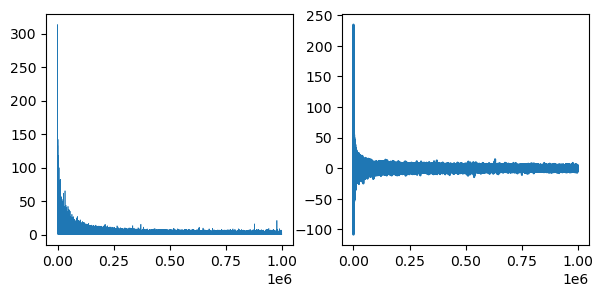

In [159]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 3
highestDominoe = 9
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 1000000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.L1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])

In [ ]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
print(f"Line available: {game.available}, dummy available: {game.dummyAvailable}")
print(f"Penny-up: {game.cantPlay}, dummy playable: {game.dummyPlayable}")
print(f"Hand-size: {game.handSize}, manualHandSize: {[len(agent.myHand) for agent in game.agents]}")
print("")
game.agents[game.nextPlayer].gameState(game.played, game.available, game.handSize, game.cantPlay, game.didntPlay, game.turnCounter, game.dummyAvailable, game.dummyPlayable)
lineOptions, dummyOptions = game.agents[game.nextPlayer].playOptions()
df.printDominoeList(lineOptions, game.agents[game.nextPlayer].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[game.nextPlayer].dominoes, name='dummy:')
dominoe, location = game.agents[game.nextPlayer].selectPlay()
if dominoe is not None:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent played dominoe: {dominoe}: {df.dominoesString(game.dominoes[dominoe])} on location: {location}.")
else:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent could not play!")
game.doTurn()

In [206]:
print("hello")

hello
